In [1]:
# Cell 1 - Setup
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [2]:
# Reproducibility (best effort; GPU ops may still be non-deterministic)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# This cell sets a random seed so the results are the same every time you run the notebook.

In [3]:
# Print versions to help reproducibility/debugging
print("Python:", os.sys.version.split()[0])
print("Numpy:", np.__version__)
print("TensorFlow:", tf.__version__)

Python: 3.12.6
Numpy: 1.26.4
TensorFlow: 2.18.0


In [8]:
# Cell 2 - Dataset selection
DATASET = "mnist"

# MNIST: 28x28 grayscale images, labels 0-9
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
input_shape = x_train.shape[1:]  # (28,28)
num_channels = 1
num_classes = 10

# Quick shapes print
print("Train X shape:", x_train.shape)
print("Train y shape:", y_train.shape)
print("Test  X shape:", x_test.shape)
print("Test  y shape:", y_test.shape)




# ➡ Here we get:
# •	x_train: 60,000 images for training
# •	y_train: labels (0–9) for each image
# •	x_test: 10,000 images for testing
# •	y_test: labels for testing
# Each MNIST image is 28×28 pixels, black and white.


Train X shape: (60000, 28, 28)
Train y shape: (60000,)
Test  X shape: (10000, 28, 28)
Test  y shape: (10000,)


In [9]:
# Cell 3 - Preprocessing
# Convert to float32 and scale to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# If MNIST, add channel dimension so shapes are consistent (N,28,28,1)
if DATASET.lower() == "mnist":
    x_train = np.expand_dims(x_train, axis=-1)  # (N,28,28,1)
    x_test  = np.expand_dims(x_test, axis=-1)

# For feedforward (fully connected) network we will flatten images to vectors
input_vector_size = int(np.prod(x_train.shape[1:]))  # e.g., 28*28*1 = 784 or 32*32*3 = 3072
print("Input vector size (flattened):", input_vector_size)

# We will use sparse integer labels with SparseCategoricalCrossentropy (no one-hot conversion needed).
# But ensure y_train / y_test shapes are (N,) not (N,1) for CIFAR:
y_train = y_train.reshape(-1,)
y_test  = y_test.reshape(-1,)
print("Labels reshaped to:", y_train.shape, y_test.shape)


# This step does:
# 1.	Converts data type to float.
# 2.	Divides by 255 → so pixel values become between 0 and 1 (makes learning easier).
# 3.	Flattens each 28×28 image into a single long row of 784 numbers.



Input vector size (flattened): 784
Labels reshaped to: (60000,) (10000,)


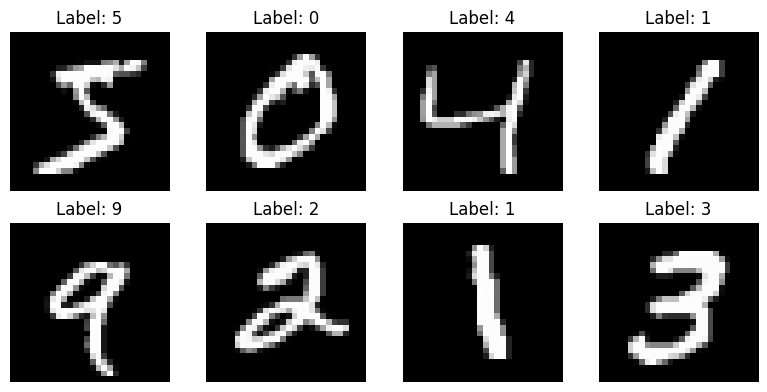

In [10]:
# Cell 4 - Visual check
plt.figure(figsize=(8,4))
n_show = 8
for i in range(n_show):
    ax = plt.subplot(2, n_show//2, i+1)
    # For MNIST grayscale squeeze channel; for CIFAR color keep channels
    img = x_train[i].squeeze()
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# This cell displays a few sample images from the training data to visually check they loaded correctly.

In [11]:
# Cell 5 - Define model (Feedforward / Fully-connected network)
from tensorflow.keras import layers, models, optimizers

hidden_units = [512, 256]   # two hidden layers: you can change sizes
dropout_rate = 0.3          # dropout to reduce overfitting
activation = "relu"

model = models.Sequential(name="ffn_flattened")
# Input: flatten the image to a vector
model.add(layers.Input(shape=(input_vector_size,)))
model.add(layers.Dense(hidden_units[0], activation=activation, name="dense_1"))
model.add(layers.Dropout(dropout_rate, name="dropout_1"))
model.add(layers.Dense(hidden_units[1], activation=activation, name="dense_2"))
model.add(layers.Dropout(dropout_rate, name="dropout_2"))
# Output layer: num_classes with softmax for classification
model.add(layers.Dense(num_classes, activation="softmax", name="output"))

# Show model summary
model.summary()


# Explanation:
# •	Optimizer: SGD (Stochastic Gradient Descent) → updates weights gradually to reduce error.
# •	Learning rate: how fast the model learns.
# •	Loss: measures how far predictions are from correct answers.
# •	Metrics: accuracy shows performance.


Model: "ffn_flattened"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Cell 6 - Compile with SGD optimizer
learning_rate = 0.01
momentum = 0.9

optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
# We use sparse categorical crossentropy because labels are integer class indices (0..9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

# This cell compiles the model using the SGD optimizer and sets loss function and accuracy as metrics.


In [13]:
# Cell 7 - Flatten training and test images into vectors for FFN
x_train_flat = x_train.reshape((-1, input_vector_size))
x_test_flat  = x_test.reshape((-1, input_vector_size))

print("x_train_flat shape:", x_train_flat.shape)
print("x_test_flat  shape:", x_test_flat.shape)

# Optionally create a validation split from training set (useful for monitoring)
val_split = 0.1
val_count = int(x_train_flat.shape[0] * val_split)
if val_count > 0:
    x_val_flat = x_train_flat[-val_count:]
    y_val = y_train[-val_count:]
    x_train_flat = x_train_flat[:-val_count]
    y_train = y_train[:-val_count]
    print("Using validation set of size:", x_val_flat.shape[0])
else:
    x_val_flat, y_val = None, None


# This cell flattens 2D image data into 1D vectors so it can be used by the feedforward network.

x_train_flat shape: (60000, 784)
x_test_flat  shape: (10000, 784)
Using validation set of size: 6000


In [ ]:
# Cell 8 - Train the model (Fixed for Keras 3.x)
batch_size = 64
epochs = 15

callbacks = [
    # Option 1: Recommended new format
    keras.callbacks.ModelCheckpoint("best_ffn.keras", save_best_only=True, monitor="val_loss")
    # Option 2 (alternative): uncomment below line if you prefer old .h5 weight format
    # keras.callbacks.ModelCheckpoint("best_ffn.h5", save_best_only=True, monitor="val_loss", save_weights_only=True)
] if x_val_flat is not None else []

history = model.fit(
    x_train_flat, y_train,
    validation_data=(x_val_flat, y_val) if x_val_flat is not None else (x_test_flat, y_test),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=callbacks,
    verbose=2
)

# Explanation:
# •	epochs: how many times the model sees the whole dataset.
# •	batch_size: how many samples to process before updating weights.
# •	validation_split: 10% data is used for checking accuracy after each epoch.
# As it trains, it prints loss and accuracy for both training and validation data.


Epoch 1/15
844/844 - 10s - 12ms/step - accuracy: 0.8704 - loss: 0.4276 - val_accuracy: 0.9592 - val_loss: 0.1441
Epoch 2/15
844/844 - 9s - 11ms/step - accuracy: 0.9427 - loss: 0.1935 - val_accuracy: 0.9717 - val_loss: 0.0999
Epoch 3/15
844/844 - 9s - 11ms/step - accuracy: 0.9572 - loss: 0.1417 - val_accuracy: 0.9758 - val_loss: 0.0857
Epoch 4/15
844/844 - 9s - 10ms/step - accuracy: 0.9649 - loss: 0.1158 - val_accuracy: 0.9767 - val_loss: 0.0795
Epoch 5/15
844/844 - 9s - 11ms/step - accuracy: 0.9703 - loss: 0.0978 - val_accuracy: 0.9798 - val_loss: 0.0704
Epoch 6/15
844/844 - 8s - 10ms/step - accuracy: 0.9741 - loss: 0.0841 - val_accuracy: 0.9792 - val_loss: 0.0670
Epoch 7/15
844/844 - 9s - 10ms/step - accuracy: 0.9772 - loss: 0.0733 - val_accuracy: 0.9815 - val_loss: 0.0645
Epoch 8/15
844/844 - 9s - 11ms/step - accuracy: 0.9797 - loss: 0.0649 - val_accuracy: 0.9817 - val_loss: 0.0618
Epoch 9/15
844/844 - 8s - 10ms/step - accuracy: 0.9817 - loss: 0.0588 - val_accuracy: 0.9817 - val_loss

In [ ]:
# Cell 9 - Plot metrics
hist = history.history
epochs_range = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, hist['loss'], label='train_loss')
# plot val_loss if available
if 'val_loss' in hist:
    plt.plot(epochs_range, hist['val_loss'], label='val_loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, hist['accuracy'], label='train_acc')
if 'val_accuracy' in hist:
    plt.plot(epochs_range, hist['val_accuracy'], label='val_acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# This cell plots graphs showing how the loss and accuracy changed during training.
# Helps you visualize:
# •	Loss curve: should go down with time.
# •	Accuracy curve: should go up with time.


In [ ]:
# Cell 10 - Evaluate and test predictions
test_loss, test_acc = model.evaluate(x_test_flat, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}    Test accuracy: {test_acc:.4f}")

# Predict probabilities on first 12 test samples and show images + predicted labels
pred_probs = model.predict(x_test_flat[:12])
pred_labels = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(10,4))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    img = x_test[i].squeeze()
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(f"GT:{y_test[i]}  P:{pred_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# This cell evaluates the model on the test dataset and prints its accuracy and loss.
# It also predicts some test images and shows their predicted labels.

In [ ]:
# Cell 11 - Save model & example single-image predict helper
model.save("ffn_model_final.keras")   # ✅ Save model properly

def predict_single_image(img_array, model):
    """
    img_array : single image as numpy array, scaled to [0,1], with channel dims.
    model expects flattened vector input.
    """
    v = img_array.reshape(1, -1).astype("float32")
    probs = model.predict(v)
    label = int(np.argmax(probs[0]))
    conf = float(np.max(probs[0]))
    return label, conf

# Example usage (first test image)
lbl, conf = predict_single_image(x_test[0], model)
print("Predicted:", lbl, "Confidence:", round(conf, 4), "Ground truth:", y_test[0])
